# `Building XGboost, Logistic Regression and Linear SVC on TFidf vectorizer`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import re
import time
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import math
from tqdm import tqdm
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import datetime as dt
from collections import Counter
from scipy.sparse import hstack
import datetime

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve


from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
#from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from subprocess import check_output
import gc
import re
import distance
from nltk.stem import PorterStemmer

#plotly related libraries:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import plotly.tools as tls

#NLP library
import spacy

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### `Preprocessed DataFrames import`

In [2]:
df = pd.read_csv('Jalesh_Preprocess.csv', encoding='latin-1')
print(len(df.columns))
print()
print('Total no of columns are:\n\n', df.columns)
print(len(df))

33

Total no of columns are:

 Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_common', 'word_total', 'word_share', 'freq_q1+freq_q2',
       'freq_q1-freq_q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len_diff', 'longest_substr_ratio', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'mean_len'],
      dtype='object')
404290


### `Dataframe sampling of 1Lpoints`

In [3]:
d = df.sample(n=100000)
print(len(d))
print(d.columns)

100000
Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_common', 'word_total', 'word_share', 'freq_q1+freq_q2',
       'freq_q1-freq_q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len_diff', 'longest_substr_ratio', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'mean_len'],
      dtype='object')


### `Functional approach of Advanced Data Cleaning on two question columns`

In [4]:
import spacy
from bs4 import BeautifulSoup
import string


nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('spacy stop words lists are: {}'.format(len(stopwords)))

SPECIAL_TOKENS = {'quoted': 'quoted_item','non-ascii': 'non_ascii_word','undefined': 'something'}


#defining function  using spacy 
def preprocessing(text, stopwords=stopwords):
    #basic replacement and preprocessing:
    
    def pad_str(s):
        return ' ' + s + ' '
    
    if pd.isnull(text):
        return ''


    # Empty question
    if type(text) != str or text=='':
        return ''

    text = str(text).lower()
    text = text.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    text = re.sub(r"([0-9]+)000000", r"\1m", text)
    text = re.sub(r"([0-9]+)000", r"\1k", text)

    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    # replace non-ascii word with special word
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text)

    #replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)

    #removing HTML, Punctuation( I am using string module) and LEMMATIZATION( using SPACY module)
    if type(text) == type(''):
        example1 = BeautifulSoup(text)
        text = example1.get_text()
    
    
    list_ = []
    
    for token in nlp(text):
        
        if token.lemma_ == '-PRON-':
            continue
        if token.is_punct:
            continue
        if token.text in stopwords:
            continue        
        else:
            list_.append(token.lemma_)
        
    text = ' '.join(list_)       
                
    return text  

spacy stop words lists are: 326


### `Data Cleaning function on two question columns`

In [5]:
%%time
q1_tokens = d['question1'].apply(lambda x: preprocessing(x))
q2_tokens = d['question2'].apply(lambda x: preprocessing(x))

CPU times: user 31min 17s, sys: 3.89 s, total: 31min 21s
Wall time: 31min 21s


In [6]:
print(q1_tokens.head(1))
print('\n\n')
print(q2_tokens.head(1))

163231    people today spend time family friend
Name: question1, dtype: object



163231    e cigarette india
Name: question2, dtype: object


### `preprocessed columns addition`

In [7]:
d['cleanedques1'] = q1_tokens
d['cleanedques2'] = q2_tokens

In [8]:
print(d.columns, '\n\n', len(d.columns))

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_common', 'word_total', 'word_share', 'freq_q1+freq_q2',
       'freq_q1-freq_q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len_diff', 'longest_substr_ratio', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'mean_len',
       'cleanedques1', 'cleanedques2'],
      dtype='object') 

 35


In [9]:
#assigning new dataframe with columns question(q1+q2) and id same as df3
d['merge_questions'] = d.cleanedques1 + ' ' + d.cleanedques2

In [10]:
d.merge_questions.head(2)

163231    people today spend time family friend e cigare...
71350     minimum mark need admission aiims delhi genera...
Name: merge_questions, dtype: object

In [11]:
df = d[['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_common',
       'word_total', 'word_share', 'freq_q1-freq_q2', 'freq_q1-freq_q2', 'merge_questions']]

In [12]:
len(df.columns)

27

In [13]:
label = d.is_duplicate
len(label)

100000

### `Train, CV, Test split`

In [64]:
xtrain, xtest, ytrain, ytest = train_test_split(df, label, test_size=0.3, stratify=label)
xtr, xcv, ytr, ycv = train_test_split(xtrain, ytrain, test_size=0.3, stratify=ytrain)

In [65]:
print(xtr.shape, ytr.shape)
print(xcv.shape, ycv.shape)
print(xtest.shape, ytest.shape)

(49000, 27) (49000,)
(21000, 27) (21000,)
(30000, 27) (30000,)


### `segregating "merge_questions" column on train,cv,and test`

In [66]:
#seperating questions for tfidf vectorizer
xtr_ques = xtr['merge_questions']
xcv_ques = xcv['merge_questions']
xtest_ques = xtest['merge_questions']

xtr = xtr.drop('merge_questions',axis=1)
xcv = xcv.drop('merge_questions', axis=1)
xtest = xtest.drop('merge_questions', axis=1)

print(xtr.shape, xcv.shape, xtest.shape)

(49000, 26) (21000, 26) (30000, 26)


In [61]:
print(xtr_ques.shape, xcv_ques.shape, xtest_ques.shape)
print(xtr_ques.values[0])

(49000,) (21000,) (30000,)
realistic quantico portrayal fbi analyst training real tv quantico


### `TFidf on two question columns`

In [67]:
%%time
tfidf = TfidfVectorizer(lowercase=False, max_features=1000)
xtr_ques = tfidf.fit_transform(xtr_ques.values)
xcv_ques = tfidf.transform(xcv_ques.values)
xtest_ques = tfidf.transform(xtest_ques.values)

CPU times: user 1.18 s, sys: 12 ms, total: 1.19 s
Wall time: 1.19 s


In [68]:
print(type(xtr_ques),'\n', type(xcv_ques), '\n',type(xtest_ques))

<class 'scipy.sparse.csr.csr_matrix'> 
 <class 'scipy.sparse.csr.csr_matrix'> 
 <class 'scipy.sparse.csr.csr_matrix'>


### `Stacking up all the numerical features into one array`

In [69]:
Xtr = hstack((xtr.values, xtr_ques))
Xcv = hstack((xcv.values, xcv_ques))
Xtest = hstack((xtest.values, xtest_ques))
#print(y.shape)

In [70]:
Xtr.shape, Xcv.shape, Xtest.shape

((49000, 1026), (21000, 1026), (30000, 1026))

### `LogisticRegression on QuoraQuestion Pair`

In [71]:
%%time
from sklearn.linear_model import LogisticRegression

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l1', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='liblinear')
    lr.fit(Xtr, ytr)
    y_pred_cv = lr.predict_proba(Xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(Xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

CPU times: user 1.93 s, sys: 60 ms, total: 1.99 s
Wall time: 1.96 s


### `Optimal C`

In [72]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)


[(10, 0.869388570542763), (100, 0.8689638636230844), (1000, 0.868918288314179), (10000, 0.8689140299412922), (0.1, 0.864691916563644), (0.01, 0.8327801378886477), (0.001, 0.8218915758626304), (0.0001, 0.7868273149694105)]
**********************************************************************
[(10, 0.8858846945819829), (100, 0.8857607337481942), (1000, 0.8857464816529088), (10000, 0.8857453594547746), (0.1, 0.8677457362985728), (0.01, 0.8351899853878707), (0.001, 0.8249748573924213), (0.0001, 0.7886378902944258)]


### `AUC of training vs test data`

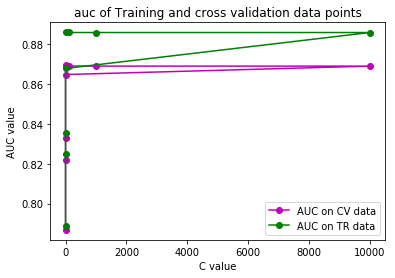

In [73]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

### `Optimal LogisticRegression`

In [80]:
%%time

lr = LogisticRegression(penalty='l1', C=10, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='liblinear')
lr.fit(Xtr, ytr)
y_pred_test = lr.predict_proba(Xtest)
y_pred_tr = lr.predict(Xtr)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
optimal_weight = lr.coef_
print(auc_test)

0.8695709198435472
CPU times: user 252 ms, sys: 0 ns, total: 252 ms
Wall time: 252 ms


### `Confusion matrix on Test Data`

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


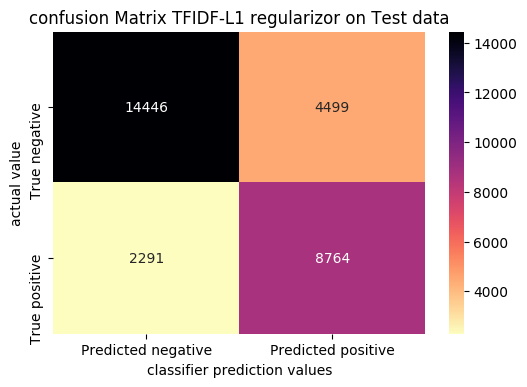

In [81]:
%time
plt.figure(dpi=100)
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
plt.subplot(111)
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix TFIDF-L1 regularizor on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

### `Confusion Matrix- Training Data`

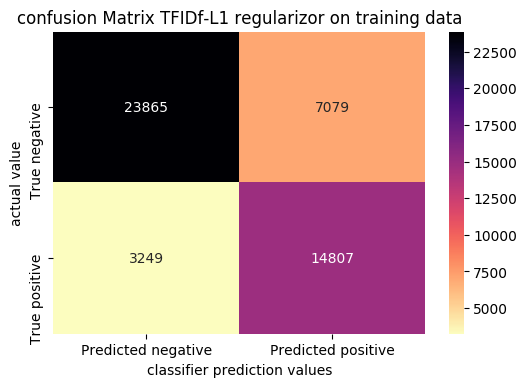

In [82]:
#y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:
plt.figure(dpi=100)
cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
plt.subplot(111)
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix TFIDf-L1 regularizor on training data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

### `ROC curve - Training vs Test data`

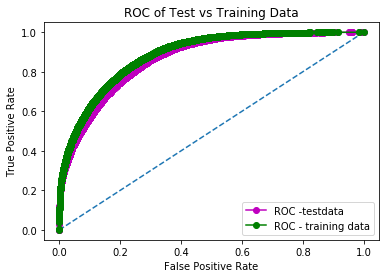

In [83]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data')
plt.legend()

## `LinearSVM on Quora Question Pair(TFidf)`

In [84]:
from sklearn.svm import LinearSVC

In [85]:
%%time
auc_cv_dict = {}
auc_tr_dict = {}
c_val = [10 **-4, 10** -3, 10 ** -2, 10 ** -1, 1, 10**1, 10 **2, 10**3, 10 ** 4]
log_error_array=[]

for i in c_val:
    svc = LinearSVC(C=i, penalty='l2', loss='hinge', class_weight='balanced', max_iter=4)
    svc.fit(Xtr, ytr)
    y_pred_cv = svc.predict(Xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv)
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    
    #performance metrics for training data:
    y_pred_tr = svc.predict(Xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr)
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

CPU times: user 1.52 s, sys: 0 ns, total: 1.52 s
Wall time: 1.52 s


### `Optimal C`

In [86]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)

[(0.01, 0.7379372087034204), (0.1, 0.7114354053166088), (10000, 0.7104546640369866), (0.001, 0.6997710788385996), (1000, 0.6820304732671824), (0.0001, 0.6706290940065145), (100, 0.633582692086041), (1, 0.6212503857384227), (10, 0.6170692384926194)]
**********************************************************************
[(0.01, 0.742540886814731), (0.1, 0.7141063978137189), (10000, 0.7130898974991742), (0.001, 0.7044933085347711), (1000, 0.6841814793479462), (0.0001, 0.6720225860576701), (100, 0.6358077380998746), (1, 0.6211947639401993), (10, 0.61883463987026)]


### `AUC curve - Training vs Test data`

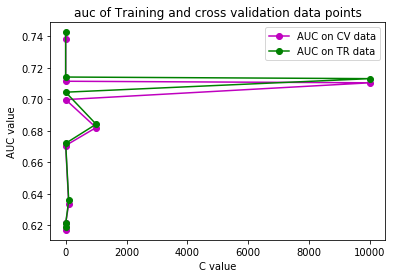

In [87]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

In [89]:
%%time

svc = LinearSVC(C=0.01, penalty='l2', loss='hinge', class_weight='balanced', max_iter=500)
svc.fit(Xtr, ytr)
y_pred_test = svc.predict(Xtest)
y_pred_tr = svc.predict(Xtr)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test)
auc_test = auc(fpr_test, tpr_test)
#optimal_weight = lr.coef_
print(auc_test)

0.7711020582683646
CPU times: user 5.25 s, sys: 4 ms, total: 5.25 s
Wall time: 5.25 s


### `Confusion Matrix - Test data`

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs


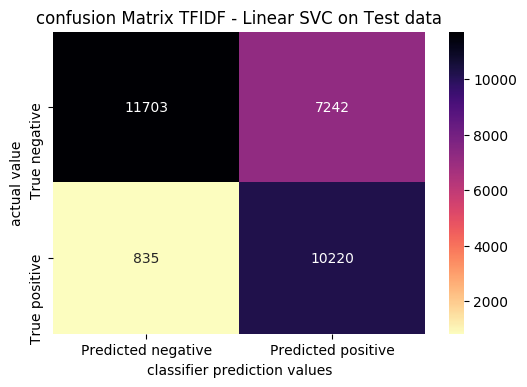

In [91]:
%time
plt.figure(dpi=100)
#y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
plt.subplot(111)
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix TFIDF - Linear SVC on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

### `Confusin matrix - Training Data`

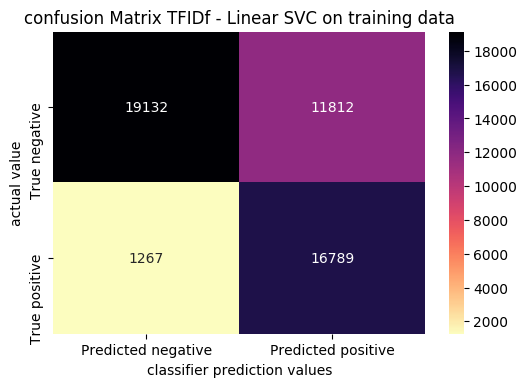

In [92]:
#y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:
plt.figure(dpi=100)
cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
plt.subplot(111)
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix TFIDf - Linear SVC on training data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

### `ROC curve`

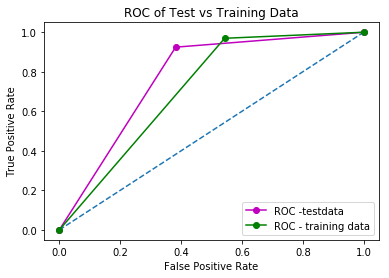

In [93]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data')
plt.legend()

# `Project 2: TFidf-W2V-XGBOOST(CLASS approach)`

### `Train,CV,Test split`

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(df, label, test_size=0.3, stratify=label)
xtr, xcv, ytr, ycv = train_test_split(xtrain, ytrain, test_size=0.3, stratify=ytrain)

### `segregation of TFidf train, cv and test vectorizer`

In [15]:
xtr_ques = xtr['merge_questions']
xcv_ques = xcv['merge_questions']
xtest_ques = xtest['merge_questions']

xtr = xtr.drop('merge_questions',axis=1)
xcv = xcv.drop('merge_questions', axis=1)
xtest = xtest.drop('merge_questions', axis=1)

print(xtr.shape, xcv.shape, xtest.shape, '\n\n', xtr_ques.shape, xcv_ques.shape, xtest_ques.shape)

(49000, 26) (21000, 26) (30000, 26) 

 (49000,) (21000,) (30000,)


In [16]:
tfidf = TfidfVectorizer(lowercase=False )
tfidf.fit_transform(xtr_ques)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

### `TFidf-W2V list for Train, CV and Test data`

In [18]:
%%time
nlp = spacy.load('en_core_web_sm')

#list of words of training dataset
xtr_vecs = []

for qu in list(xtr_ques):
    doc = nlp(qu) 
    # 384 is the number of dimensions of vectors 
    mean_vec = np.zeros([len(doc), 96])
    for word in doc:
        # word2vec
        vec = word.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        # compute final vec
        mean_vec += vec * idf
    mean_vec = mean_vec.mean(axis=0)
    xtr_vecs.append(mean_vec)
#df['q1_feats_m'] = list(vecs1)

CPU times: user 7min 8s, sys: 176 ms, total: 7min 8s
Wall time: 7min 8s


In [19]:
%%time

#list of words of cv dataset

cv_vecs = []
for qu in list(xcv_ques):
    doc = nlp(qu) 
    # 384 is the number of dimensions of vectors 
    mean_vec = np.zeros([len(doc), 96])
    for word in doc:
        # word2vec
        vec = word.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        # compute final vec
        mean_vec += vec * idf
    mean_vec = mean_vec.mean(axis=0)
    cv_vecs.append(mean_vec)


##################################################


#list of words of test dataset:

test_vecs = []
for qu in list(xtest_ques):
    doc = nlp(qu) 
    # 384 is the number of dimensions of vectors 
    mean_vec = np.zeros([len(doc), 96])
    for word in doc:
        # word2vec
        vec = word.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        # compute final vec
        mean_vec += vec * idf
    mean_vec = mean_vec.mean(axis=0)
    test_vecs.append(mean_vec)

CPU times: user 7min 29s, sys: 288 ms, total: 7min 30s
Wall time: 7min 30s


### `Series Creation for Train, CV and Test data`

In [21]:
train_df = pd.DataFrame(xtr_vecs)
cv_df = pd.DataFrame(cv_vecs)
test_df = pd.DataFrame(test_vecs)

In [22]:
train_df.shape

(49000, 96)

In [23]:
cv_df.shape

(21000, 96)

In [24]:
%%time
tfidf = TfidfVectorizer(lowercase=False, max_features=1000)
xtr_ques = tfidf.fit_transform(xtr_ques.values)
xcv_ques = tfidf.transform(xcv_ques.values)
xtest_ques = tfidf.transform(xtest_ques.values)

CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.2 s


### `stacking SPARSE matrix and ndarray along the column`

In [25]:
Xtr = hstack((train_df.values, xtr_ques))
Xcv = hstack((cv_df.values, xcv_ques))
Xtest = hstack((test_df.values, xtest_ques))


In [26]:
print(Xtr.shape, '\n', Xcv.shape, '\n', Xtest.shape)

(49000, 1096) 
 (21000, 1096) 
 (30000, 1096)


## `TFidf-W2V-XGBOOST(CLASS approach)`

In [27]:
from xgboost.sklearn import XGBClassifier

class XGB:

    '''building the XGboostRandom Forest classifier based off hypeparameters no_of_base_models and max_depth of base_models'''
    
    #instantiating the instance attributes:
    def __init__(self, xtr, ytr, xcv, ycv, maximum_depth=[1, 2, 3, 4], estimators=[10, 20, 30, 40, 50, 60, 70]):
        self.xtr = xtr
        self.ytr = ytr
        self.xcv = xcv
        self.ycv = ycv
        self.estimators = estimators
        self.maximum_depth = maximum_depth
    
    #creating a method of calling RF classifier:
    def classfier(self, auc_dict_cv={}, auc_dict_tr={}):
        for estimator in self.estimators:
            for depths in self.maximum_depth: 
                clf = XGBClassifier(booster='gbtree',silent=0,max_depth=depths, n_estimators=estimator, learning_rate=0.1)
                print(depths, estimator)
                clf.fit(self.xtr, self.ytr)
                y_pred_cv = clf.predict_proba(self.xcv)
                
                #performance metric on CV data:                
                fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
                auc_val = auc(fpr_cv, tpr_cv)
                auc_dict_cv[auc_val] = [estimator, depths]
                
                #performance metrics for training data:
                y_pred_tr = clf.predict_proba(self.xtr)
                fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
                auc_val = auc(fpr_tr, tpr_tr)
                auc_dict_tr[auc_val] = [estimator, depths]
                
        return auc_dict_tr, auc_dict_cv

## `TFidfXGB instance creation from XGB class`

In [28]:
import time
start = time.time()
Tfidf_instance = XGB(Xtr, ytr, Xcv, ycv)

dictionary_train, dictionary_cv = Tfidf_instance.classfier()
end = time.time()

print('time is(in seconds): ', end - start)

1 10
2 10
3 10
4 10
1 20
2 20
3 20
4 20
1 30
2 30
3 30
4 30
1 40
2 40
3 40
4 40
1 50
2 50
3 50
4 50
1 60
2 60
3 60
4 60
1 70
2 70
3 70
4 70
time is(in seconds):  389.2402036190033


## `Optimal estimator and depth Search`

In [29]:
train_list = [[np.round(x, 5), y] for x, y in dictionary_train.items()]
cv_list = [[np.round(x, 5), y] for x, y in dictionary_cv.items()]

print(train_list[0])

print()
print(cv_list[0])

tr_list = sorted(train_list, key=lambda x: x[0], reverse=True)
cv_list = sorted(cv_list, key=lambda x: x[0], reverse=True)
print('sorted train list score based off AUC score is:\n', tr_list[0:3])
print('****************************************')
print()
print('sorted CV list score based off AUC score is:\n', cv_list[0:3])

[0.6535, [10, 1]]

[0.62298, [10, 1]]
sorted train list score based off AUC score is:
 [[0.76289, [70, 4]], [0.7581, [60, 4]], [0.75294, [50, 4]]]
****************************************

sorted CV list score based off AUC score is:
 [[0.71706, [70, 4]], [0.71369, [60, 4]], [0.70997, [50, 4]]]


## `AUC- Training vs Test data`

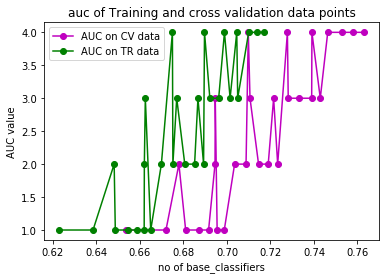

In [30]:
plt.plot([x[0] for x in tr_list], [x[1][1] for x in tr_list], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in cv_list], [x[1][1] for x in cv_list], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("no of base_classifiers")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

## `Optimal XGBoost classifier(max depth =4, n_estimators=70)`

In [31]:
%%time

clfxgb = XGBClassifier(booster='gbtree',silent=0,max_depth=4, n_estimators=70, learning_rate=0.1, class_weight='balanced')
clfxgb.fit(Xtr, ytr)

#prediction on training data:
y_pred_tr = clfxgb.predict_proba(Xtr)
fpr_tr, tpr_tr, thresholds_tr= roc_curve(ytr, y_pred_tr[:,1])
auc_tr = auc(fpr_tr, tpr_tr)

#prediction on test data:
ypred = clfxgb.predict_proba(Xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, ypred[:,1])
auc_test = auc(fpr_test, tpr_test)

print(auc_test)

0.7309184923214378
CPU times: user 1min 52s, sys: 340 ms, total: 1min 53s
Wall time: 31.3 s


## `Confusion matrix- Test data`

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


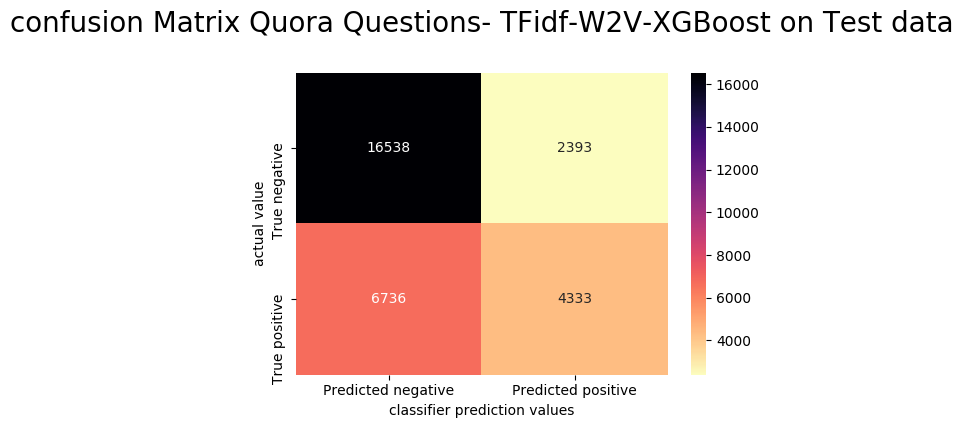

In [32]:
%time
plt.figure(dpi=100)
ypred = np.where(ypred[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, ypred)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
plt.subplot(111)
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix Quora Questions- TFidf-W2V-XGBoost on Test data\n", size=20)
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

## `Confusion matrix - training data`

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs


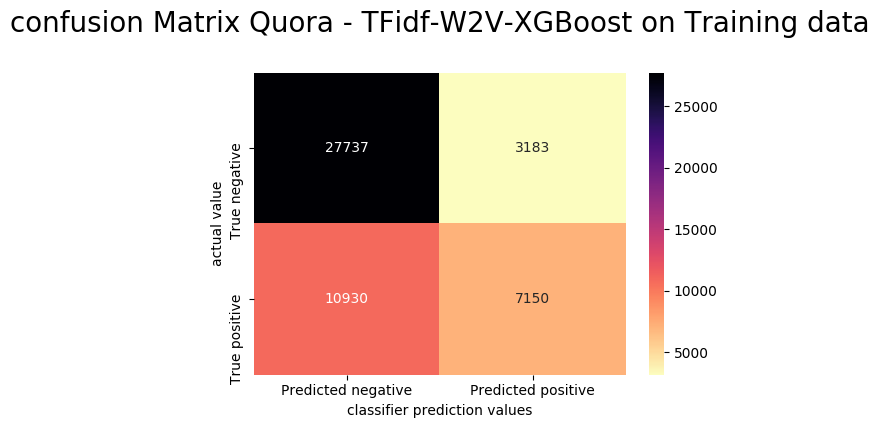

In [33]:
%time
plt.figure(dpi=100)
y_pred_tr = np.where(y_pred_tr[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
plt.subplot(111)
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix Quora - TFidf-W2V-XGBoost on Training data\n", size=20)
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

## `ROC-AUC Curve - Training vs Test Data`

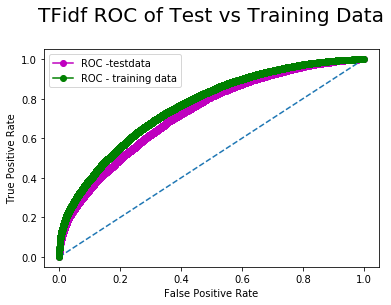

In [34]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TFidf ROC of Test vs Training Data\n', size=20)
plt.legend()


## `Heatmap`

Text(0.5, 1.0, ' Heatmap of Cross_Validation AUC value vs no_base_models and depths')

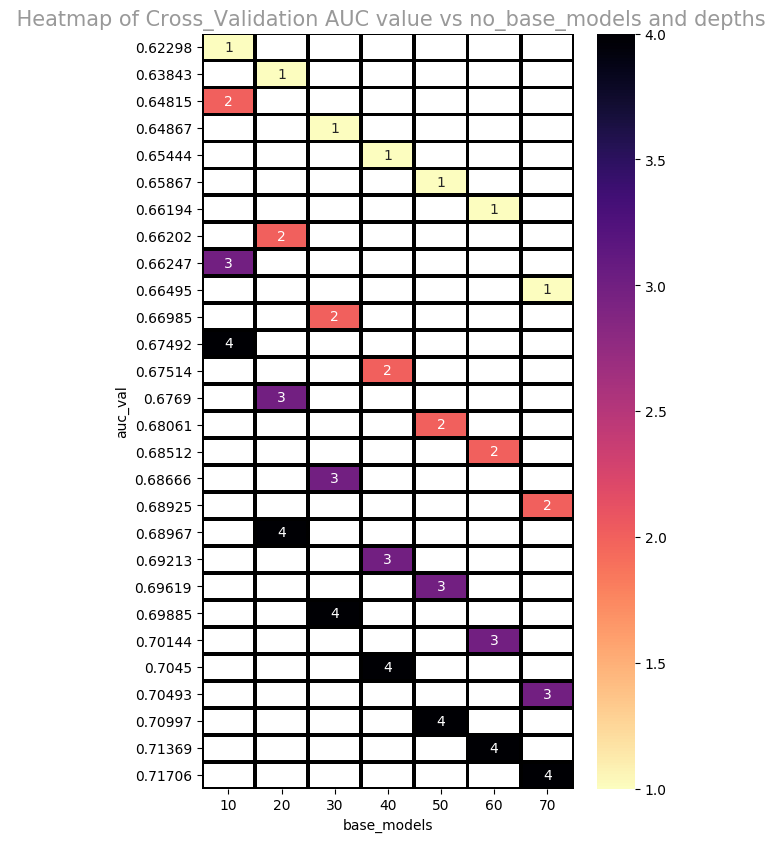

In [35]:
#creating dataframe for pivot table:
auc_scores = []
no_base_models = []
no_depths = []

for i in range(len(cv_list)):
    auc_scores.append(cv_list[i][0])
    no_base_models.append(cv_list[i][1][0])
    no_depths.append(cv_list[i][1][1])
    
df_dict = dict(base_models=no_base_models,
              depths=no_depths,
              auc_val=auc_scores)
d_dframe = pd.DataFrame(df_dict)
#d_dframe.head(4)



#plotting heatmap:
fig = plt.figure(figsize=(6, 10), dpi=100)
d_pivot = d_dframe.pivot('auc_val','base_models', 'depths')
sns.heatmap(d_pivot, annot=True, cmap='magma_r', linecolor='black', linewidth=2)
plt.title(' Heatmap of Cross_Validation AUC value vs no_base_models and depths', size=15, color='#999999')

# `Conclusion - Out of 1L datapoints:`




***`1. I have extensively used SPACY in this project for stopwords, punctuation removal, token creation etc.`***

***`2. XGB-Tfidf-W2V AUC performace with ~76 % AUC score when used only with 1000 features.`***

***`3. Heatmap is created of AUC_Score wrt Depth and no_of_classifiers for TFIDF XGB vectorizers.`***

***`4. Applied hyperparameter tuning on both Logistic regression and LinearSVM in order to search and train optimal model.`***